In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Settings import Settings
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

import joblib
settings = Settings()
settings

{'pf1': 0.4,
 'pf2': 0.3,
 'sample_size': 2000,
 'prices': array([ 10.,  20.,  30.,  60., 100.], dtype=float32),
 'c1_reasonable_price': 30,
 'c1_elasticity': 0.1,
 'c1_skepticism': 0.01,
 'c1_max_conversion_rate': 0.75,
 'c1_noise_reasonable_price': 0,
 'c1_noise_elasticity': 0.0,
 'c1_noise_max_conversion_rate': 0.0,
 'c2_reasonable_price': 50,
 'c2_elasticity': 0.05,
 'c2_skepticism': 0.05,
 'c2_max_conversion_rate': 0.85,
 'c2_noise_reasonable_price': 0,
 'c2_noise_elasticity': 0.0,
 'c2_noise_max_conversion_rate': 0.0,
 'c3_reasonable_price': 40,
 'c3_elasticity': 0.1,
 'c3_skepticism': 0.008,
 'c3_max_conversion_rate': 0.5,
 'c3_noise_reasonable_price': 0,
 'c3_noise_elasticity': 0.0,
 'c3_noise_max_conversion_rate': 0.0,
 'default_noise': 0.0}

(0.0, 1.0)

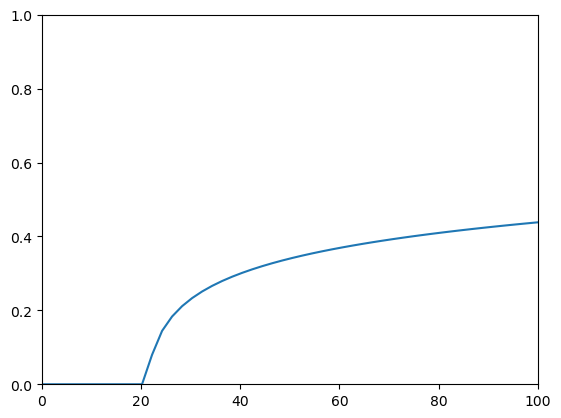

In [3]:
def stuff(x, min_budget, max_budget,  vel):
    if x < min_budget + 1:
        return 0
    else:
        curve = vel * np.log(x - min_budget)
        #min between max_budget and curve
        return min(max_budget, curve)

x = np.linspace(0, 200, 100)
y = [stuff(x, 20, 100, 0.1) for x in x]

plt.plot(x, y)
plt.xlim(0, 100)
plt.ylim(0, 1)
    

In [4]:
def bid_clicks_curve(x, min_bid = 10, steepness = 0.055, max_clicks = 60):

    if x < min_bid:
        return 0
    return  max_clicks * (1 - np.exp(-steepness * (x - min_bid)))

x = np.linspace(0,100, 100)
y_hat = [y(el) for el in x]

plt.plot(x, y_hat)


TypeError: 'list' object is not callable

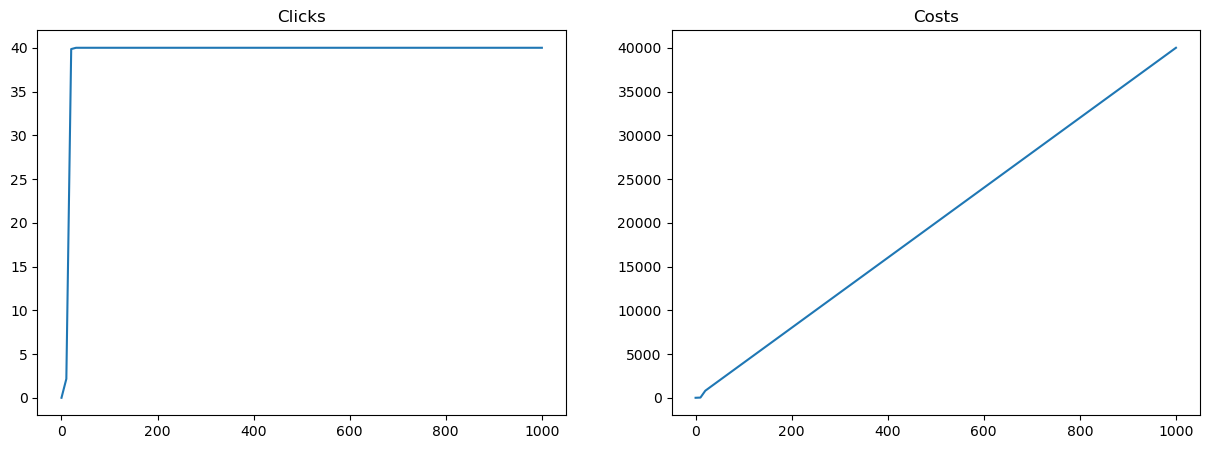

In [2]:
class AA:
    def __init__(self):
        self.bids = np.linspace(0.0, 100, 10)
    def get_clicks(self, bid, _user_class, min_bid = 10):
        # Define the function for number of clicks for a specific class
        # Return the number of clicks based on the bid and user class
        configs = {"C1": {"max_clicks": 40, "steepness": 0.55, "noise" : 1.0},
                   "C2": {"max_clicks": 80, "steepness": 0.95, "noise" : 2.0},
                   "C3": {"max_clicks": 50, "steepness": 1.2, "noise" : 4}}
        max_clicks = configs[_user_class]["max_clicks"]
        steepness = configs[_user_class]["steepness"]
        noise = configs[_user_class]["noise"]

        if bid < min_bid:
            return 0
        ret_val =   max_clicks * (1 - np.exp(-steepness * (bid - min_bid)))

        return ret_val # + np.random.normal(0, noise)

    def get_costs(self, bid, _user_class, scale_factor = 1):
        return bid * scale_factor * self.get_clicks(bid, _user_class)
    
    def clicks_learning(self, _user_class):
        n_obs = 10
        # for the 3 classes need to change the parameters a bit
        x_obs = np.array([])
        y_obs = np.array([])
        noise_std = 5.0

        for i in range(0, n_obs):
            new_x_obs = np.random.choice(self.bids, 1)
            new_y_obs = self.get_clicks(new_x_obs, _user_class)
            print("=" * 10, f"iteration: {i}", "=" * 10)
            print(f"new x obs: {new_x_obs}")
            print(f"new y obs: {new_y_obs}")

            x_obs = np.append(x_obs, new_x_obs)
            y_obs = np.append(y_obs, new_y_obs)

            X = np.atleast_2d(x_obs).T
            Y = y_obs.ravel()

            theta = 1.0
            l = 1.0
            kernel = C(theta, (1e-3, 1e3)) * RBF(l, (1e-3, 1e3))
            gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_std ** 2, normalize_y=True,
                                          n_restarts_optimizer=10)  # alpha=noise_std**2

            gp.fit(X, Y)

            x_pred = np.atleast_2d(self.bids).T
            y_pred, sigma = gp.predict(x_pred, return_std=True)

            print(f"y_pred: {y_pred}")
            print(f"sigma: {sigma}")


            plt.figure(figsize=(10, 5))
            plt.plot(x_pred, y_pred, 'b-', label=u'Prediction')
            plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
            plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
                        np.concatenate([y_pred - 1.9600 * sigma,
                                        (y_pred + 1.9600 * sigma)[::-1]]),
                        alpha=.5, fc='b', ec='None', label='95% confidence interval')
            plt.xlabel('$x$')
            plt.ylabel('$f(x)$')
            plt.ylim(0, 100)
            plt.legend(loc='upper left')
            plt.show()

env = AA()
bids = np.linspace(0, 1000, 100)
clicks = [env.get_clicks(bid, "C1") for bid in bids]
costs = [env.get_costs(bid, "C1") for bid in bids]

#plot on two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(bids, clicks)
ax1.set_title("Clicks")
ax2.plot(bids, costs)
ax2.set_title("Costs")
plt.show()


========== iteration: 0 ==========
new x obs: [100.]
new y obs: [40.]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [40. 40. 40. 40. 40. 40. 40. 40. 40. 40.]
sigma: [0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278
 0.03162278 0.03162278 0.03162278 0.03162214]


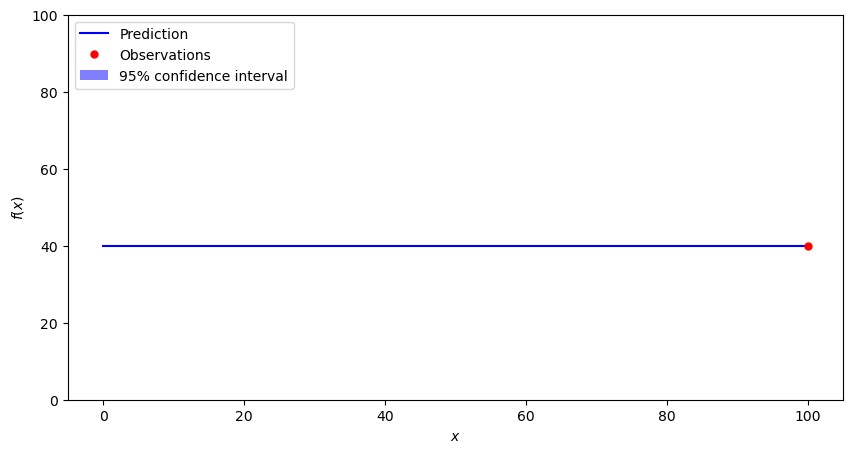

========== iteration: 1 ==========
new x obs: [22.22222222]
new y obs: [39.9518456]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [39.9759228  39.9759228  39.97592184 39.9759228  39.9759228  39.9759228
 39.9759228  39.9759228  39.9759228  39.97592376]
sigma: [0.00076139 0.00076139 0.00076137 0.00076139 0.00076139 0.00076139
 0.00076139 0.00076139 0.00076139 0.00076137]


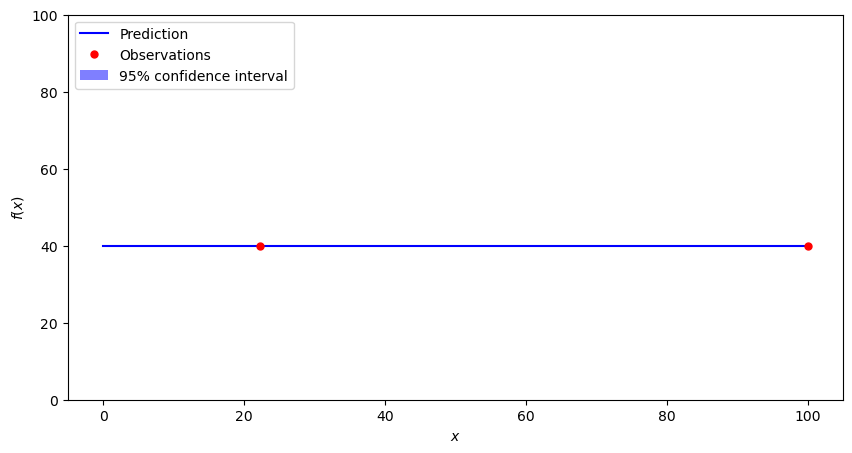

========== iteration: 2 ==========
new x obs: [44.44444444]
new y obs: [39.99999976]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [39.98394845 39.98394845 39.98394717 39.98394845 39.9839491  39.98394845
 39.98394845 39.98394845 39.98394845 39.9839491 ]
sigma: [0.00071784 0.00071784 0.00071783 0.00071784 0.00071783 0.00071784
 0.00071784 0.00071784 0.00071784 0.00071783]


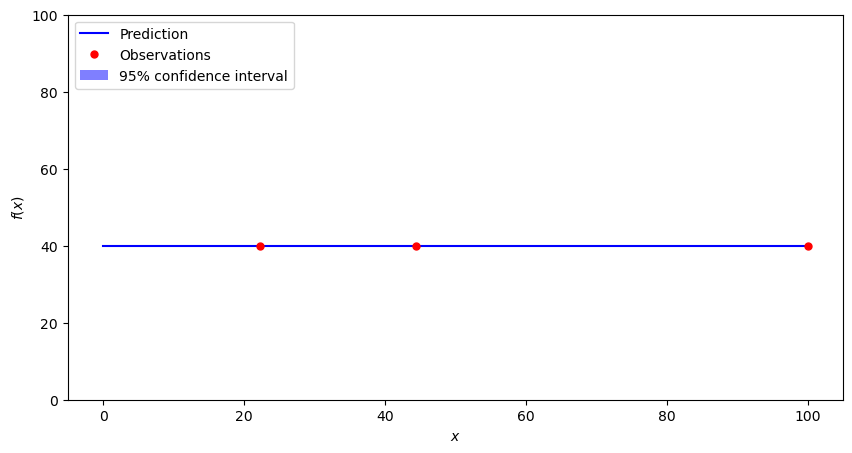

========== iteration: 3 ==========
new x obs: [100.]
new y obs: [40.]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [39.98796134 39.98796134 39.9879599  39.98796134 39.98796182 39.98796134
 39.98796134 39.98796134 39.98796134 39.9879623 ]
sigma: [0.00065938 0.00065938 0.00065937 0.00065938 0.00065937 0.00065938
 0.00065938 0.00065938 0.00065938 0.00065935]


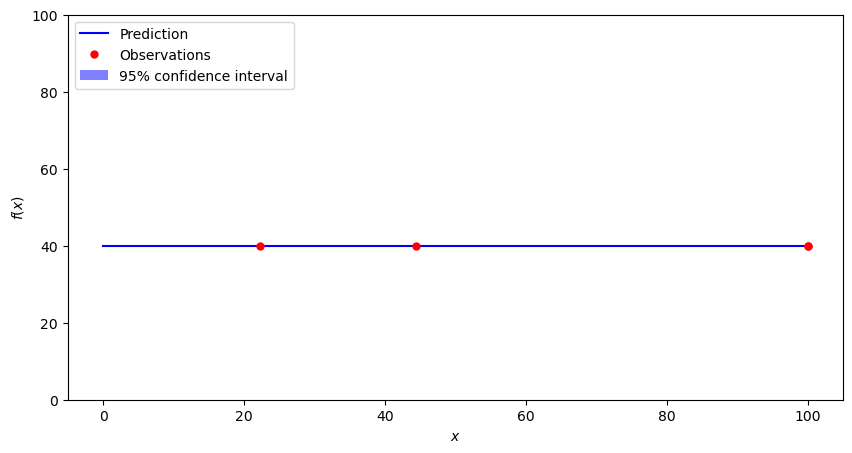

========== iteration: 4 ==========
new x obs: [11.11111111]
new y obs: [18.29010075]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [35.64838922 35.64769492 35.64856135 35.64838922 35.64856328 35.64838922
 35.64838922 35.64838922 35.64838922 35.64873732]
sigma: [0.27445927 0.27445378 0.27445378 0.27445927 0.27445378 0.27445927
 0.27445927 0.27445927 0.27445927 0.2744483 ]


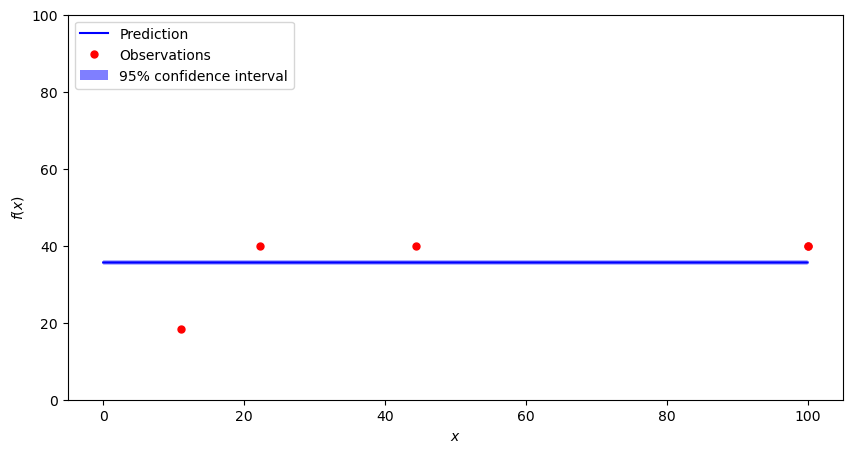

========== iteration: 5 ==========
new x obs: [22.22222222]
new y obs: [39.9518456]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [36.36563195 36.36490896 36.36591883 36.36563195 36.36577732 36.36563195
 36.36563195 36.36563195 36.36563195 36.36592268]
sigma: [0.25562752 0.25562241 0.2556173  0.25562752 0.25562241 0.25562752
 0.25562752 0.25562752 0.25562752 0.2556173 ]


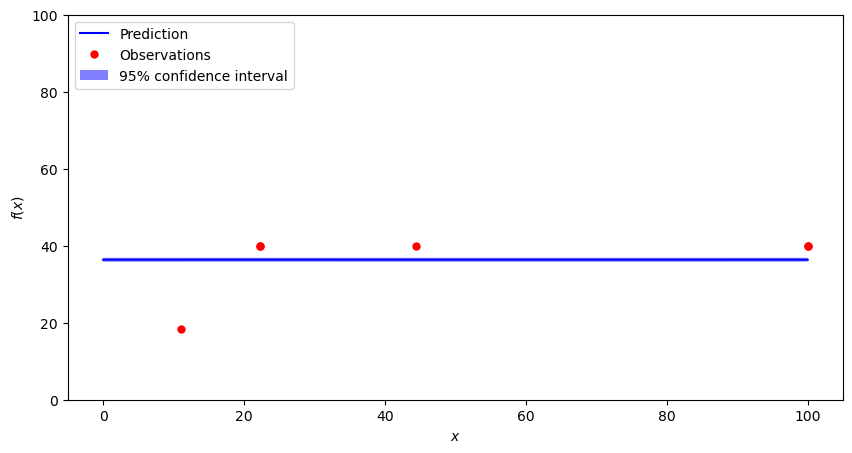

========== iteration: 6 ==========
new x obs: [77.77777778]
new y obs: [40.]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [36.88482739 36.88408363 36.88507273 36.88482739 36.88495199 36.88482739
 36.88482739 36.88495199 36.88482739 36.88507658]
sigma: [0.24005781 0.24005301 0.24004821 0.24005781 0.24005301 0.24005781
 0.24005781 0.24005301 0.24005781 0.24004821]


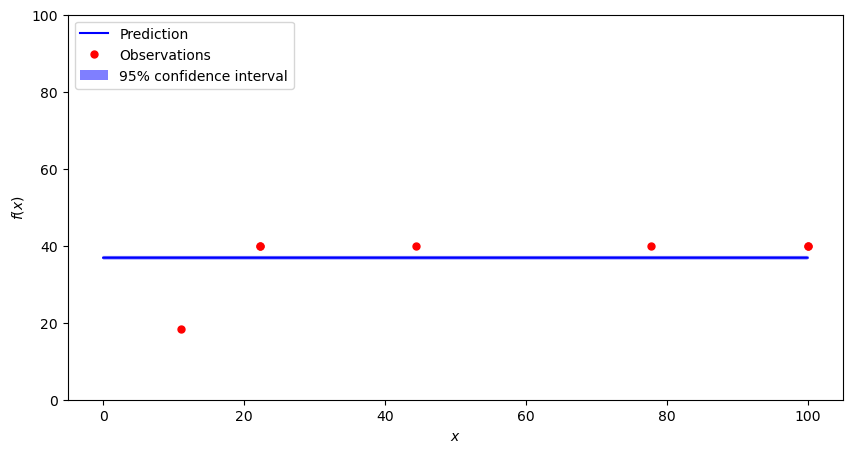

========== iteration: 7 ==========
new x obs: [100.]
new y obs: [40.]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [37.27422396 37.27346463 37.27443816 37.27422396 37.27433299 37.27422396
 37.27422396 37.27433299 37.27422396 37.27455102]
sigma: [0.22690458 0.22690005 0.22689551 0.22690458 0.22690005 0.22690458
 0.22690458 0.22690005 0.22690458 0.22689097]


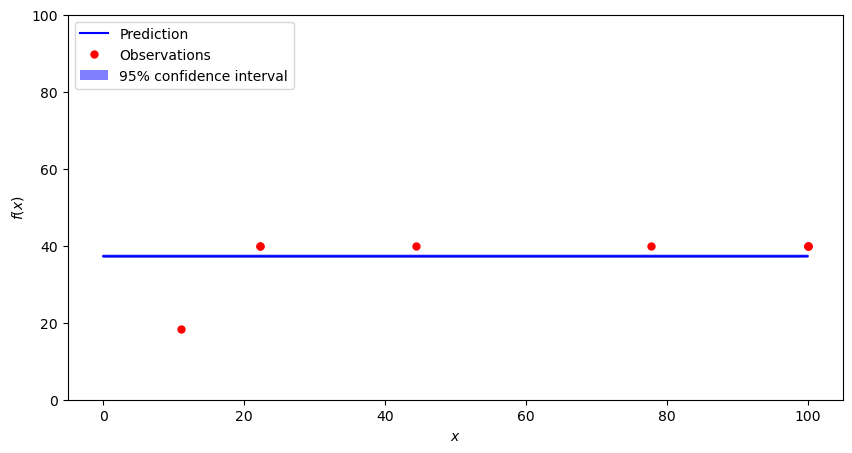

========== iteration: 8 ==========
new x obs: [77.77777778]
new y obs: [40.]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [37.57708797 37.57631652 37.57727793 37.57708797 37.57718488 37.57708797
 37.57708797 37.57728179 37.57708797 37.57737868]
sigma: [0.21563597 0.21563166 0.21562734 0.21563597 0.21563166 0.21563597
 0.21563597 0.21562734 0.21563597 0.21562303]


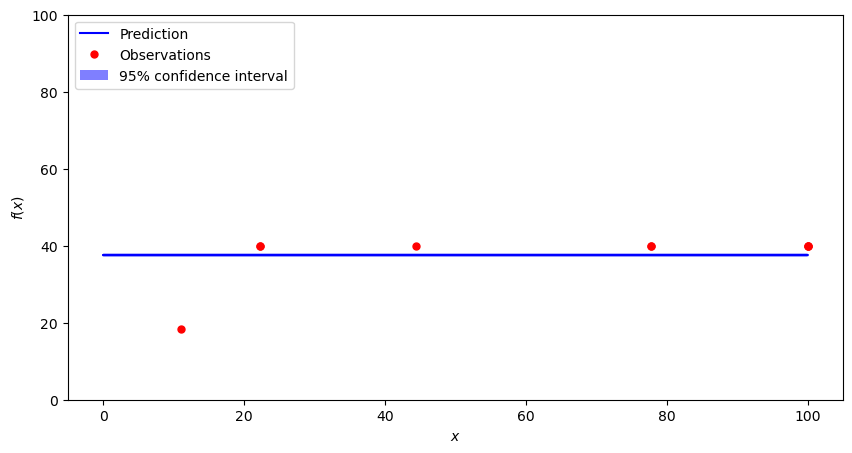

========== iteration: 9 ==========
new x obs: [44.44444444]
new y obs: [39.99999976]


c:\Users\Alessandro\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


y_pred: [37.81937915 37.81859801 37.81954973 37.81937915 37.81955358 37.81937915
 37.81937915 37.81955358 37.81937915 37.81964079]
sigma: [0.20585755 0.20585343 0.20584931 0.20585755 0.20584931 0.20585755
 0.20585755 0.20584931 0.20585755 0.2058452 ]


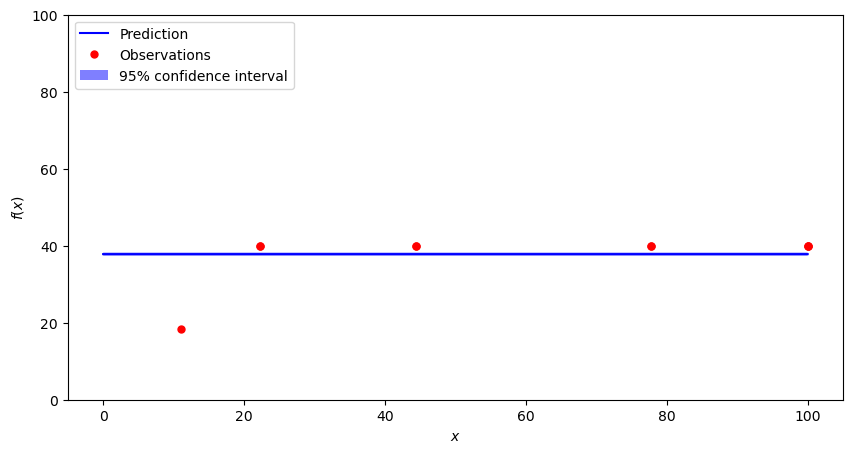

In [3]:
env.clicks_learning("C1")